###DOWNLOAD DATASET:

Perform the following steps to load the dataset into your Google Colab,
1. Open Kaggle -> Your Profile -> Account -> Create New API Token
2. Copy the kaggle.json into your Google Drive under the location "/content/drive/MyDrive/Colab Notebooks/kaggle.json"
3. Run the below commands in the Notebook


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:

! cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/

In [ ]:
! chmod +x /root/.kaggle/kaggle.json

In [ ]:

! mkdir breast-histopathology-images

In [ ]:
! cd breast-histopathology-images && kaggle datasets download paultimothymooney/breast-histopathology-images

 99% 3.07G/3.10G [00:21<00:00, 210MB/s]
100% 3.10G/3.10G [00:21<00:00, 157MB/s]


In [ ]:
! cd breast-histopathology-images && unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_



#Data Pre-Processing
In this section, we load the images and store them in proper format

In [ ]:
import os, shutil
import matplotlib.pyplot as plt
import keras.utils as image
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, Activation, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
import keras.backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix, roc_curve
import seaborn as sns

### Seggregate positive and negative samples into lists

In [ ]:
B_samples = []
M_samples = []
for dirname, _, filenames in os.walk('/content/breast-histopathology-images/IDC_regular_ps50_idx5'):
    for filename in filenames:
      path = os.path.join(dirname, filename)
      if path.split('/')[-2] == '0':
        B_samples.append(path)
      elif path.split('/')[-2] == '1':
        M_samples.append(path)
      else:
        print(f"Invalid path: {path}")
print("Printing first 5 Benign Samples")
for sample in B_samples[:5]:
  print(sample)
print("Printing first 5 Malignant Samples")
for sample in M_samples[:5]:
  print(sample)

Printing first 5 Benign Samples
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/0/16531_idx5_x901_y1101_class0.png
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/0/16531_idx5_x401_y701_class0.png
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/0/16531_idx5_x601_y801_class0.png
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/0/16531_idx5_x801_y351_class0.png
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/0/16531_idx5_x551_y251_class0.png
Printing first 5 Malignant Samples
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/1/16531_idx5_x801_y1051_class1.png
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/1/16531_idx5_x851_y1701_class1.png
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/1/16531_idx5_x651_y1001_class1.png
/content/breast-histopathology-images/IDC_regular_ps50_idx5/16531/1/16531_idx5_x1101_y1951_class1.png
/content/breast-histopathol

### Organize data into dataframes

In [ ]:
df_1 = pd.DataFrame(M_samples, columns=['path'])
df_0 = pd.DataFrame(B_samples, columns=['path'])
df = pd.concat([df_1, df_0])
df.head()

,path
0,/content/breast-histopathology-images/IDC_regu...
1,/content/breast-histopathology-images/IDC_regu...
2,/content/breast-histopathology-images/IDC_regu...
3,/content/breast-histopathology-images/IDC_regu...
4,/content/breast-histopathology-images/IDC_regu...


In [ ]:
def format_image_ids(x):
  return x.split('/')[-1]

def format_patient_ids(x):
    return x.split('_')[0]

def format_targets(x):
    return x.split('_')[-1][5]

df['image_id'] = df['path'].apply(format_image_ids)
df['patient_id'] = df['image_id'].apply(format_patient_ids)
df['target'] = df['image_id'].apply(format_targets)
df.head()

,path,image_id,patient_id,target
0,/content/breast-histopathology-images/IDC_regu...,16531_idx5_x801_y1051_class1.png,16531,1
1,/content/breast-histopathology-images/IDC_regu...,16531_idx5_x851_y1701_class1.png,16531,1
2,/content/breast-histopathology-images/IDC_regu...,16531_idx5_x651_y1001_class1.png,16531,1
3,/content/breast-histopathology-images/IDC_regu...,16531_idx5_x1101_y1951_class1.png,16531,1
4,/content/breast-histopathology-images/IDC_regu...,16531_idx5_x701_y951_class1.png,16531,1


# Exploratory Data Analysis (EDA)

*   List item
*   List item


We look at useful patterns in data to derive meaningful insights

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 198737
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   path        277524 non-null  object
 1   image_id    277524 non-null  object
 2   patient_id  277524 non-null  object
 3   target      277524 non-null  object
dtypes: object(4)
memory usage: 10.6+ MB


<ipython-input-87-26176e8284da>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.groupby('patient_id').size(), ax=ax[0], color='Orange', kde=False, bins=30)
<ipython-input-87-26176e8284da>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cancer_perc.loc[:, '1']*100, ax=ax[1], color="Tomato", 

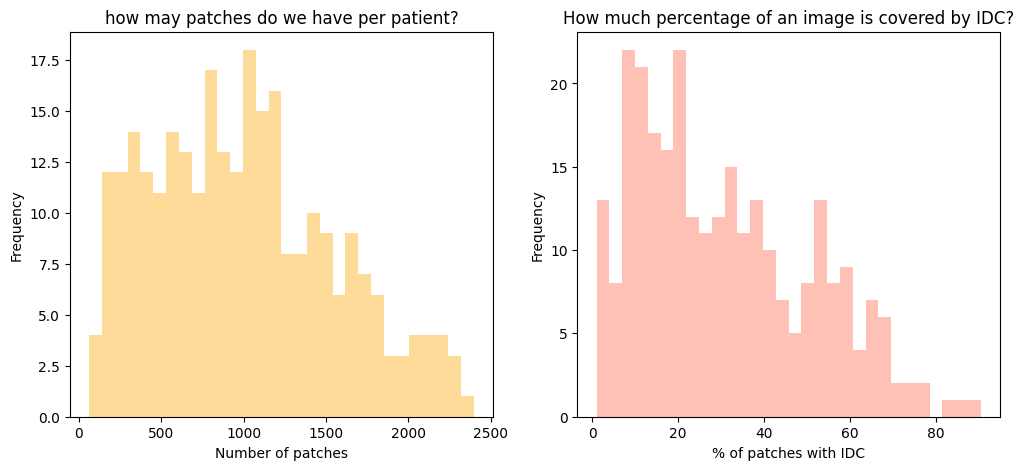

In [ ]:
cancer_perc = df.groupby("patient_id").target.value_counts() / df.groupby("patient_id").target.size()
canxer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 2,figsize = (12,5))
sns.distplot(df.groupby('patient_id').size(), ax=ax[0], color='Orange', kde=False, bins=30)
ax[0].set_xlabel('Number of patches')
ax[0].set_ylabel('Frequency')
ax[0].set_title('how may patches do we have per patient?')
sns.distplot(cancer_perc.loc[:, '1']*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");

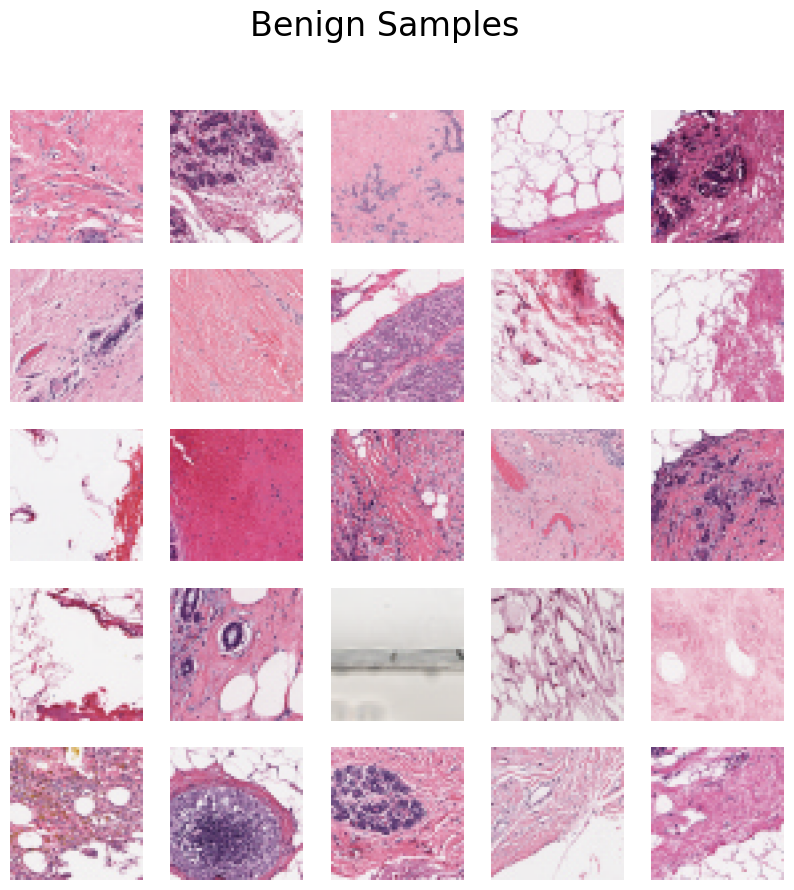

In [ ]:
#displaying Benign samples
B_count = len(B_samples)
M_count = len(M_samples)
plt.figure(figsize = (10, 10))
plt.suptitle("Benign Samples", fontsize=24)
s = 0
for i in np.random.randint(0, B_count, 25):
  img = image.load_img((B_samples[i]), target_size=(100, 100))
  img = image.img_to_array(img)
  plt.subplot(5, 5, s+1)
  plt.axis('off')
  plt.imshow(img.astype('uint8'))
  s += 1


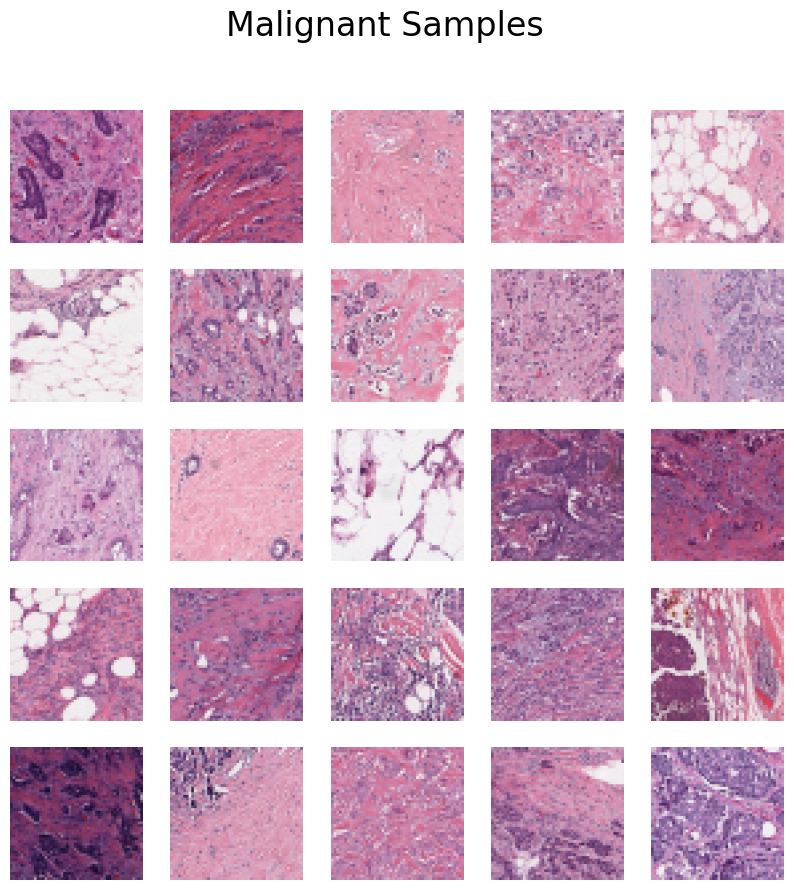

In [ ]:
#displaying Malignant samples
plt.figure(figsize = (10, 10))
plt.suptitle("Malignant Samples", fontsize=24)
s = 0
for i in np.random.randint(0, M_count, 25):
  img = image.load_img((M_samples[i]), target_size=(100, 100))
  img = image.img_to_array(img)
  plt.subplot(5, 5, s+1)
  plt.axis('off')
  plt.imshow(img.astype('uint8'))
  s += 1

In [ ]:
from matplotlib.image import imread
import cv2

B_images = []
M_images = []
for sample in B_samples:
  b_image = cv2.imread(sample, cv2.IMREAD_COLOR)
  # Interpolation methods ( cv2.INTER_CUBIC and cv2.INTER_LANCZOS4 - higher quality, smoother images images | cv2.INTER_LINEAR -smooth images and is fast )
  b_image_resize = cv2.resize(b_image, (50, 50), interpolation = cv2.INTER_LINEAR)
  B_images.append([b_image_resize, 0])

for sample in M_samples:
  m_image = cv2.imread(sample, cv2.IMREAD_COLOR)
  # Interpolation methods ( cv2.INTER_CUBIC and cv2.INTER_LANCZOS4 - higher quality, smoother images images | cv2.INTER_LINEAR -smooth images and is fast )
  m_image_resize = cv2.resize(m_image, (50, 50), interpolation = cv2.INTER_LINEAR)
  M_images.append([m_image_resize, 1])
print("Printing first 5 Benign Images")
for img in B_images[:5]:
  print(img)
print("Printing first 5 Malignant Images")
for img in M_images[:5]:
  print(img)




Printing first 5 Benign Images
[array([[[113,  74, 134],
        [155, 121, 183],
        [159, 128, 170],
        ...,
        [240, 241, 242],
        [240, 241, 242],
        [240, 241, 242]],

       [[145, 105, 159],
        [126,  86, 155],
        [178, 147, 215],
        ...,
        [240, 241, 241],
        [240, 241, 241],
        [240, 241, 241]],

       [[181, 159, 219],
        [140,  97, 148],
        [137, 103, 167],
        ...,
        [240, 241, 241],
        [240, 241, 241],
        [240, 241, 241]],

       ...,

       [[136, 106, 150],
        [161, 126, 188],
        [136,  96, 151],
        ...,
        [239, 242, 242],
        [240, 239, 242],
        [239, 239, 239]],

       [[150, 113, 163],
        [135,  93, 144],
        [144, 104, 156],
        ...,
        [237, 240, 240],
        [242, 236, 243],
        [236, 239, 242]],

       [[141, 105, 161],
        [111,  72, 122],
        [159, 124, 185],
        ...,
        [238, 238, 242],
        [237, 242

In [ ]:
import random
X = []
Y= []
img_dataset = np.concatenate((B_images, M_images))
#random.shuffle(img_dataset)
for img in img_dataset:
  feature = img[0]
  label = img[1]
  X.append(feature)
  Y.append(label)
X = np.array(X)
Y = np.array(Y)
print('X shape : {}' .format(X.shape))

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


X shape : (277524, 50, 50, 3)


Number of Benign samples: 198738
Number of Malignant samples: 78786
Total Number of samples: 277524


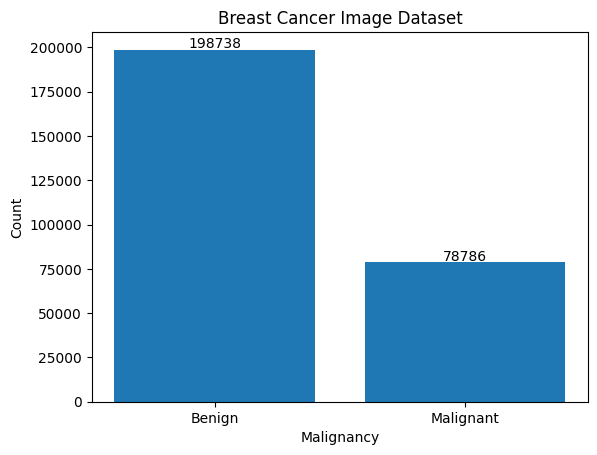

In [ ]:
B_count = len(B_samples)
M_count = len(M_samples)
print(f"Number of Benign samples: {B_count}")
print(f"Number of Malignant samples: {M_count}")
print(f"Total Number of samples: {B_count + M_count}")
y_axis = [B_count, M_count]
x_axis = ['Benign', 'Malignant']
plt.bar(x_axis, y_axis)
plt.title('Breast Cancer Image Dataset')
plt.xlabel('Malignancy')
plt.ylabel('Count')
for i, v in enumerate(y_axis):
    plt.text(i, v+1000, str(v), ha='center')
plt.show()

Text(0.5, 1.0, 'Pie Plot of each class(0 , 1)')

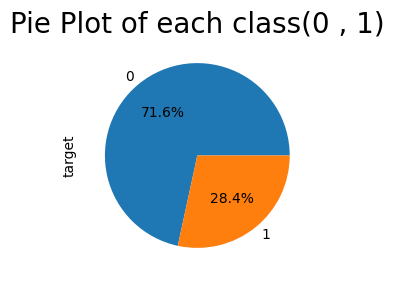

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
df["target"].value_counts().plot.pie(autopct = "%1.1f%%")
plt.title('Pie Plot of each class(0 , 1)',size = 20)

# Handling Imbalanced Data
We observe above that the class distribution is highly unbalanced in this dataset. So we balance it using RandomOversampler

In [ ]:
X = df.loc[:, df.columns != 'target']
Y = df['target']
oversample = RandomOverSampler(sampling_strategy='minority')
#reshaping the image data into a 2-dimensional feature matrix to make it compatible with the oversampling method
X_resampled, Y_resampled = oversample.fit_resample(X, Y)
print('X shape : {}' .format(X_resampled.shape))
print('Y shape : {}' .format(Y_resampled.shape))

X shape : (397476, 3)
Y shape : (397476,)


Number of Benign samples: 198738
Number of Malignant samples: 198738
Total Number of samples: 397476


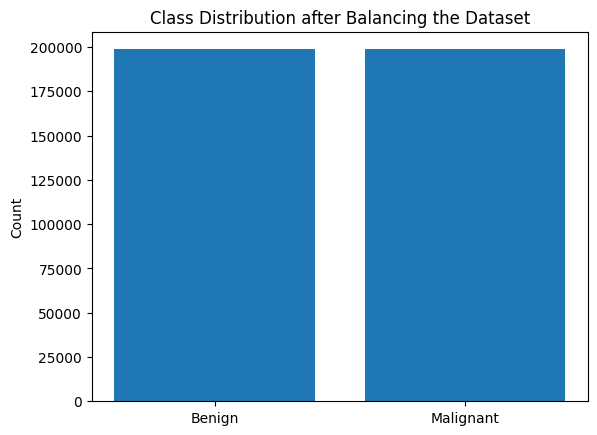

In [ ]:
counts = np.bincount(Y_resampled)
print(f"Number of Benign samples: {counts[0]}")
print(f"Number of Malignant samples: {counts[1]}")
print(f"Total Number of samples: {counts[0] + counts[1]}")
y_axis = counts
x_axis = ['Benign', 'Malignant']
plt.bar(x_axis, y_axis)
plt.ylabel('Count')
plt.title('Class Distribution after Balancing the Dataset')
plt.show()

Text(0.5, 1.0, 'Pie Plot of each class(0 , 1)')

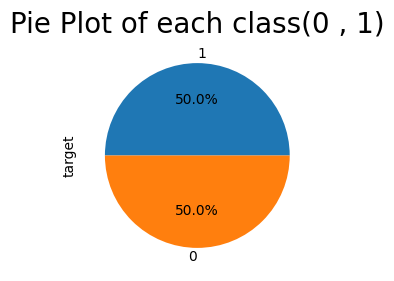

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
Y_resampled.value_counts().plot.pie(autopct = "%1.1f%%")
plt.title('Pie Plot of each class(0 , 1)',size = 20)

# Train Test Split
Once the dataset is balanced, we split the data into train, test and validation datasets. 85% data is kept for training and 15% for testing. The 85% data is further split into 75% training dataset and 15% validation dataset.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.15, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train = X_resampled
y_train = Y_resampled

# Organize Train, Test, Validation Images into folders

In [ ]:
def create_dirs(dir):
  if not os.path.exists(dir):
    os.mkdir(dir)
    os.mkdir(os.path.join(dir, '1'))
    os.mkdir(os.path.join(dir, '0'))

train_dir = os.path.join('train_dir')
val_dir = os.path.join('val_dir')
test_dir = os.path.join('test_dir')

create_dirs(train_dir)
create_dirs(val_dir)
create_dirs(test_dir)

train_list = list(X_train['image_id'])
val_list = list(X_val['image_id'])
test_list = list(X_test['image_id'])

def save_imgs(img_list, img_dir):
  for image in img_list:
      pat_id = format_patient_ids(image)
      label = format_targets(image)
      src = 'breast-histopathology-images/' + pat_id + '/' + label + '/' + image
      dst =  os.path.join(img_dir, label, image)
      shutil.copyfile(src, dst)

save_imgs(train_list, train_dir)
save_imgs(val_list, val_dir)
save_imgs(test_list, test_dir)

# Image Augmentation
We perform image augmenation to generate new transformed versions of images from the given image dataset to increase its diversity.

In [ ]:
image_size = 100

# create temporary directories here and delete these directories later
aug_dir = 'aug_dir'
os.mkdir(aug_dir)
# create a dir within the base dir to store images of the same class
img_dir = os.path.join(aug_dir, 'img_dir')
os.mkdir(img_dir)

# list all images in that directory
img_list = os.listdir('train_dir/1')

# copy images from the class all images directory to the image directory
for fname in img_list:
    # source path to image
    src = os.path.join('train_dir/1', fname)
    # destination path to image
    dst = os.path.join(img_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# point to a dir containing the images and not to the images themselves
path = 'aug_dir'
save_path = 'train_dir/1'

# create a data generator
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.125,
    height_shift_range=0.125,
    zoom_range=[1.2, 1.325],
    fill_mode='reflect')

batch_size = 25

aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size)

# generate the augmented images and add them to the folder of all images

num_aug_images_wanted = len(os.listdir('train_dir/0')) # total number of images wanted in each class

num_files = len(os.listdir(img_dir))
num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

for i in range(0, num_batches):
  next(aug_datagen)

# delete temporary directory with the raw image files
shutil.rmtree('aug_dir')

Found 78786 images belonging to 1 classes.


In [ ]:
train_path = 'train_dir'
valid_path = 'val_dir'
test_path = 'test_dir'

num_train_samples = len(X_train)
num_val_samples = len(X_val)
num_test_samples = len(X_test)

train_batch_size = 500
val_batch_size = 500
test_batch_size = 500

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                             horizontal_flip=True,
                             vertical_flip=True)

train_batches_bench = datagen.flow_from_directory(train_path, 
                                                  target_size=(image_size, image_size),
                                                  batch_size=train_batch_size)

valid_batches_bench = datagen.flow_from_directory(valid_path,  
                                                  target_size=(image_size, image_size),
                                                  batch_size=val_batch_size)

test_batches_bench = datagen.flow_from_directory(test_path,  
                                                 target_size=(image_size, image_size),
                                                 batch_size=1,
                                                 shuffle=False) # test dataset should not be shuffled

Found 397485 images belonging to 2 classes.
Found 47542 images belonging to 2 classes.
Found 55157 images belonging to 2 classes.


# Build Baseline Model


In [ ]:
def build_baseline_model():
  baseline = Sequential()
  baseline.add(Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
  baseline.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
  baseline.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
  baseline.add(MaxPooling2D(pool_size=2))
  baseline.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
  baseline.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
  baseline.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
  baseline.add(MaxPooling2D(pool_size=2))
  baseline.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
  baseline.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
  baseline.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
  baseline.add(MaxPooling2D(pool_size=2))
  baseline.add(Dropout(0.35))
  baseline.add(Flatten())
  baseline.add(Dense(256, activation='relu'))
  baseline.add(Dropout(0.5))
  baseline.add(Dense(2, activation='softmax'))
  return baseline
baseline = build_baseline_model()
baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        9248      
                                                        

# Train Baseline Model

In [ ]:
class_weights={
    0: 1.0, # negative
    1: 1.0, # postive 
}
baseline.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpointer_baseline = ModelCheckpoint(filepath='baseline.hdf5', verbose=1, save_best_only=True,monitor='val_accuracy')
history_baseline = baseline.fit(train_batches_bench, 
                                            steps_per_epoch=train_steps, 
                                            class_weight=class_weights,
                                            validation_data=valid_batches_bench,
                                            validation_steps=val_steps,
                                            callbacks=[checkpointer_baseline], 
                                            epochs=30, 
                                            verbose=1)
# ! cp baseline.hdf5 /content/drive/MyDrive/Colab\ Notebooks

# Baseline Model Evaluation

55304/55304 [==============================] - 127s 2ms/step
              precision    recall  f1-score   support

    negative       0.86      0.84      0.85     29762
    positive       0.82      0.84      0.83     25542

    accuracy                           0.84     55304
   macro avg       0.84      0.84      0.84     55304
weighted avg       0.84      0.84      0.84     55304

Accuracy: 0.839%
Balanced Accuracy: 0.839%


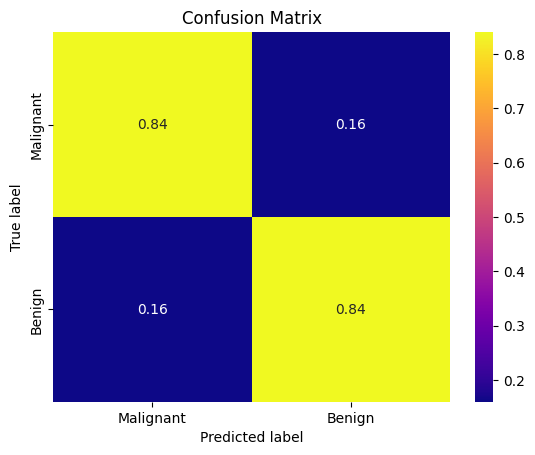

In [ ]:
baseline.load_weights('/content/drive/MyDrive/Colab Notebooks/baseline.hdf5')
preds = baseline.predict(test_batches_bench, steps=len(test_batches_bench), verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_batches_bench.classes
report = classification_report(y_true=y_true, y_pred=y_pred, target_names=['negative', 'positive'])
print(report)
print(f'Accuracy: {accuracy_score(y_true, y_pred):1.3f}%')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):1.3f}%')

def plot_confusion_matrix(y_true, y_pred):
  classes = ['Malignant','Benign']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_true, y_pred,normalize='true')
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(y_true, y_pred)

# Build Transfer Learning Model
We see that the baseline CNN model had an accuracy of around 83%. We attempt to improve this by using Transfer Learning to add a VGG16 model on top of CNN along with a few Dense layers.

## Regularization:
While building the model itself, we perform few regularization techniques. We apply L2 Regularization with a lambda value of 0.0001. Also, we add Dropouts with 0.5 threshold after Dense layers to avoid overfitting. And we already applied Image Augmentation too to get a more generalized model.

In [ ]:
def build_vgg():
  base = VGG16(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))
  base.load_weights('/content/drive/MyDrive/Colab Notebooks/baseline.hdf5', by_name=True)
  for layer in base.layers:
    layer.trainable = False
  last = base.output
  x = GlobalAveragePooling2D()(last)
  x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
  # x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  preds = Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)(x)
  # preds = Dense(2, activation='softmax')(x)
  vgg = Model(base.input, preds)
  vgg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  vgg.summary()
  return vgg
vgg = build_vgg()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

# Training the VGG16 Transfer Learning Model

In [ ]:
class_weights={
    0: 1.0, # negative
    1: 1.0, # postive 
}
vgg.load_weights('/content/drive/MyDrive/Colab Notebooks/vgg.hdf5')
checkpointer_vgg = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/vgg.hdf5', monitor='val_accuracy', verbose=1, 
                            mode='max')
history_vgg = vgg.fit(train_batches_bench, 
                                       steps_per_epoch=train_steps, 
                                       class_weight=class_weights,
                                       validation_data=valid_batches_bench,
                                       validation_steps=val_steps,
                                       callbacks=[checkpointer_vgg], 
                                       epochs=30, 
                                       verbose=1)

Epoch 1/30
795/795 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.8893


Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/vgg.hdf5
795/795 [==============================] - 290s 363ms/step - loss: 0.2644 - accuracy: 0.8893 - val_loss: 0.3614 - val_accuracy: 0.8409
Epoch 2/30
795/795 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8902
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/vgg.hdf5
795/795 [==============================] - 258s 325ms/step - loss: 0.2623 - accuracy: 0.8902
Epoch 3/30
795/795 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8900
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/vgg.hdf5
795/795 [==============================] - 259s 326ms/step - loss: 0.2620 - accuracy: 0.8900
Epoch 4/30
795/795 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.8900
Epoch 4: saving model to /content/drive/MyDrive/Colab Notebooks/vgg.hdf5
795/795 [==============================] - 260s 326ms/step - loss: 0.2609 - accuracy: 0.8900
Epoch

# Transfer Learning Model Evaluation
We generate final predictions of our transfer learning model and observe that, with Transfer Learning, the model accuracy significantly increases to 91%. We continue to generate reports and visualize accuracy and loss plots as shown below

55157/55157 [==============================] - 133s 2ms/step
              precision    recall  f1-score   support

    negative       0.91      0.92      0.91     29762
    positive       0.89      0.75      0.90     25395

    accuracy                           0.89     55157
   macro avg       0.91      0.90      0.89     55157
weighted avg       0.91      0.90      0.89     55157

Accuracy: 0.915%
Balanced Accuracy: 0.911%


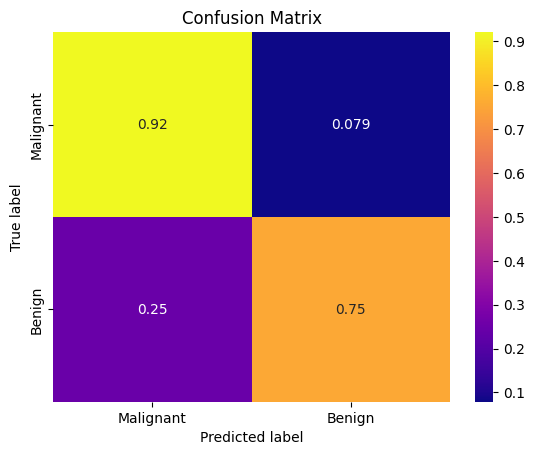

In [ ]:
vgg.load_weights('/content/drive/MyDrive/Colab Notebooks/vgg.hdf5')
preds = vgg.predict(test_batches_bench, steps=len(test_batches_bench), verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_batches_bench.classes
report = classification_report(y_true=y_true, y_pred=y_pred, target_names=['negative', 'positive'])
print(report)
print(f'Accuracy: {accuracy_score(y_true, y_pred):1.3f}%')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):1.3f}%')

def plot_confusion_matrix(y_true, y_pred):
  classes = ['Malignant','Benign']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_true, y_pred,normalize='true')
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(y_true, y_pred)

In [ ]:
history_vgg = pd.DataFrame(history_vgg)
history_vgg.head()

,loss,accuracy,val_accuracy,val_loss
0,0.326108,0.855493,0.879318,0.312854
1,0.281495,0.878289,0.890242,0.286315
2,0.261309,0.886730,0.893022,0.278547
3,0.251268,0.891822,0.895138,0.274294
4,0.247469,0.893138,0.896537,0.271900


Text(0.5, 1.0, 'Training and Validation Accuracy')

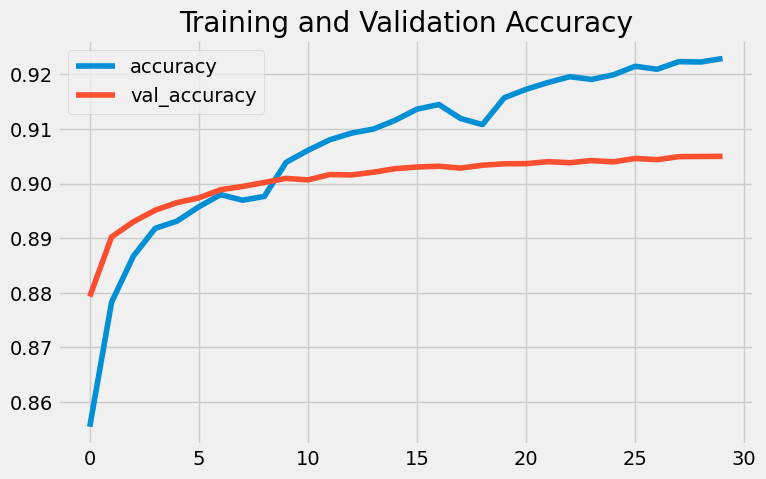

In [ ]:
plt.style.use('fivethirtyeight')
history_vgg[['accuracy','val_accuracy']].plot(figsize=(8,5))
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

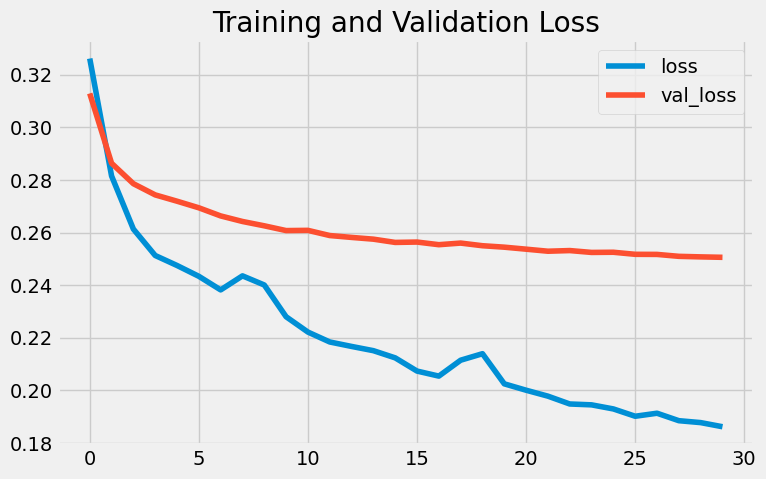

In [ ]:
plt.style.use('fivethirtyeight')
history_vgg[['loss','val_loss']].plot(figsize=(8,5))
plt.title('Training and Validation Loss')

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.3 MB/s eta 0:00:00


# Hyperparameter Tuning
Lastly, we performed hyperparamter tuning using BayesianOptimization and  train the model again with the best params we get. The final accuracy we get is 91% on unseen data.

In [ ]:
from kerastuner.tuners import BayesianOptimization
ep = 10
mt = 3
tuner = BayesianOptimization(build_vgg, objective = "accuracy", max_trials = mt, executions_per_trial = 1, 
                             seed = 2020, project_name = "vgg16_tuning", overwrite = True)
tensorboard = TensorBoard(log_dir = path, histogram_freq = 1)
tuner.search(train_data, validation_data = valid_data, steps_per_epoch = len(train_data), validation_steps = len(valid_data), 
             epochs = ep, callbacks = [EarlyStopping('val_loss', patience = 2), tensorboard])
best_hp = pd.DataFrame(tuner.get_best_hyperparameters()[0].values, index = [0])
print(best_hp)
print('Best Score: ', best_score)

   dropout_base_model  dense  dropout
0                 0.5    256      0.5
Best Score: 0.91
